**Linear Regression Analysis of Snowpack in Western US and ENSO**

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
!pip install shap
import shap

In [2]:
# import data
ds1 = xr.open_dataset("westus_pt1.nc")
ds2 = xr.open_dataset("westus_pt2.nc")

# standardize the time columns between both datasets
ds1['valid_time'] = ds1.valid_time.dt.floor('D')
ds2['valid_time'] = ds2.valid_time.dt.floor('D')

# and merge
ds = xr.merge([ds1, ds2])
ds

/tmp/ipykernel_946/719437503.py:10: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds1, ds2])
/tmp/ipykernel_946/719437503.py:10: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds1, ds2])


<xarray.Dataset> Size: 268MB
Dimensions:     (valid_time: 1030, latitude: 101, longitude: 161)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2025-10-01
  * latitude    (latitude) float64 808B 50.0 49.75 49.5 ... 25.5 25.25 25.0
  * longitude   (longitude) float64 1kB -144.0 -143.8 -143.5 ... -104.2 -104.0
    expver      (valid_time) <U4 16kB '0001' '0001' '0001' ... '0001' '0005'
Data variables:
    tp          (valid_time, latitude, longitude) float32 67MB ...
    sf          (valid_time, latitude, longitude) float32 67MB ...
    t2m         (valid_time, latitude, longitude) float32 67MB ...
    sst         (valid_time, latitude, longitude) float32 67MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-01T02:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
print(ds.data_vars)

Data variables:
    tp       (valid_time, latitude, longitude) float32 67MB ...
    sf       (valid_time, latitude, longitude) float32 67MB ...
    t2m      (valid_time, latitude, longitude) float32 67MB ...
    sst      (valid_time, latitude, longitude) float32 67MB ...


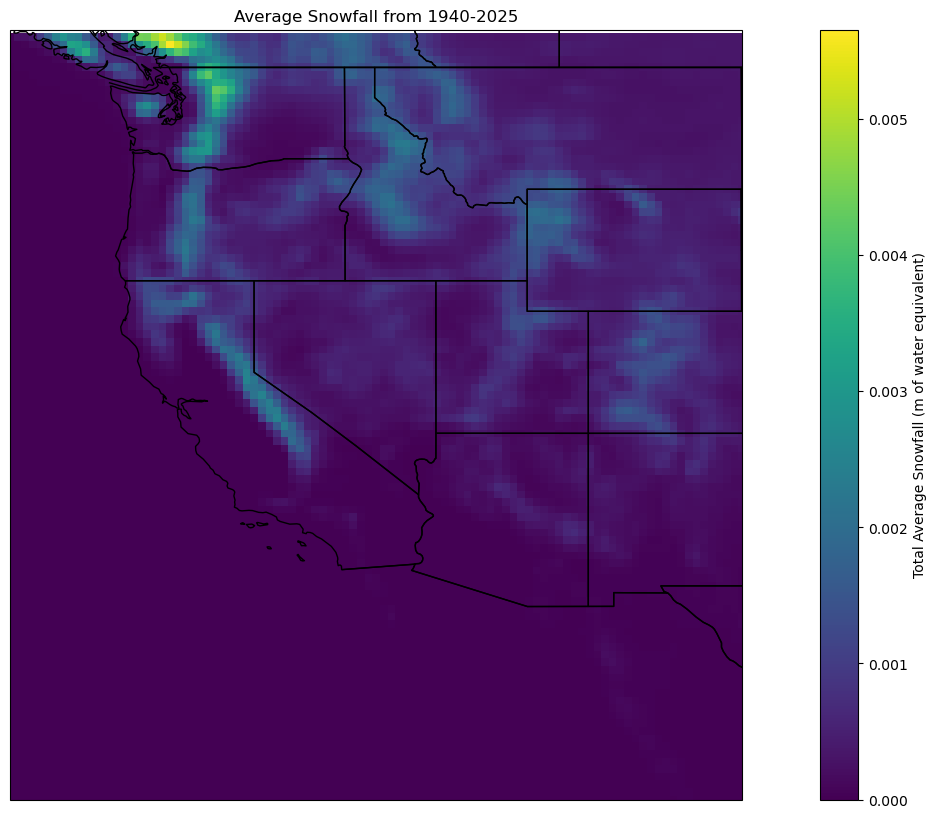

In [4]:
# But first! I think it will be fun to include a map of snowfall data.
# To map snowfall data, need to collapse the dataset into 2D by taking the average over the entire time series 
ave_snowfall = ds['sf'].mean(dim='valid_time')

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())  
ax.set_extent([-128, -104, 25, 50])   
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES) 
cbar = ave_snowfall.plot(ax=ax, transform=ccrs.PlateCarree())
cbar.colorbar.set_label('Total Average Snowfall (m of water equivalent)')
ax.set_title("Average Snowfall from 1940-2025")
plt.show()


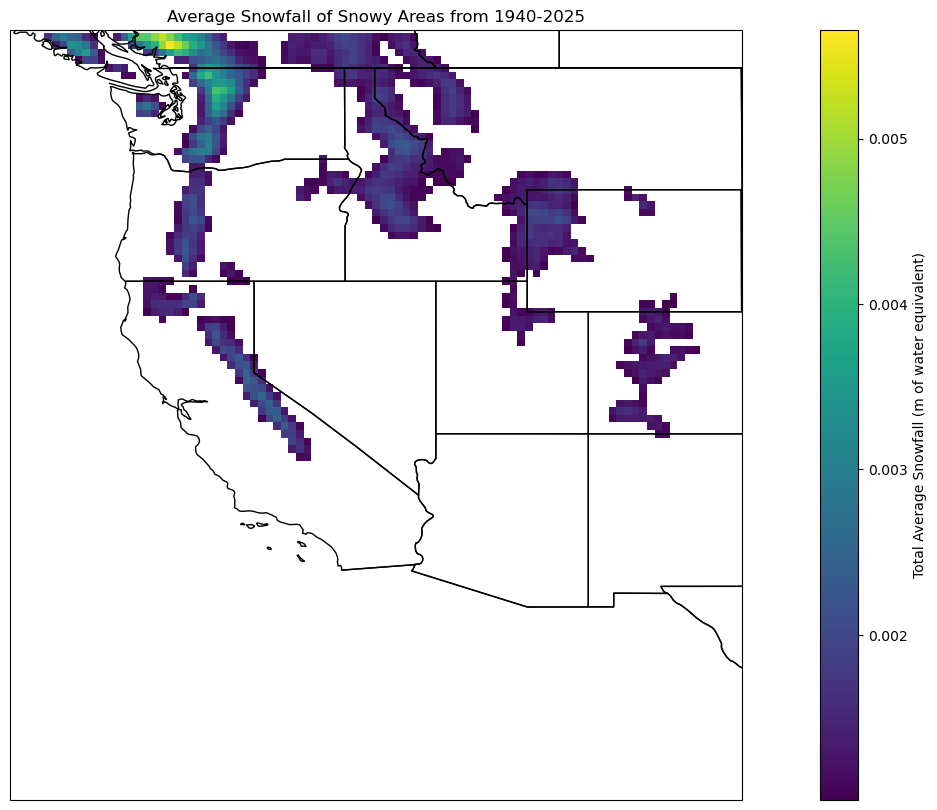

In [5]:
# I only want to study regions that are "snowy"
# For this assignment, "snowy" is defined as areas where the 1940-2025 average snowfall is >0.001 m.

snow_mask = ave_snowfall > 0.001
ds_snow = ds.where(snow_mask)

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())  
ax.set_extent([-128, -104, 25, 50])   
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES) 
cbar = ds_snow['sf'].mean(dim='valid_time').plot(ax=ax, transform=ccrs.PlateCarree())
cbar.colorbar.set_label('Total Average Snowfall (m of water equivalent)')
ax.set_title("Average Snowfall of Snowy Areas from 1940-2025")
plt.show()

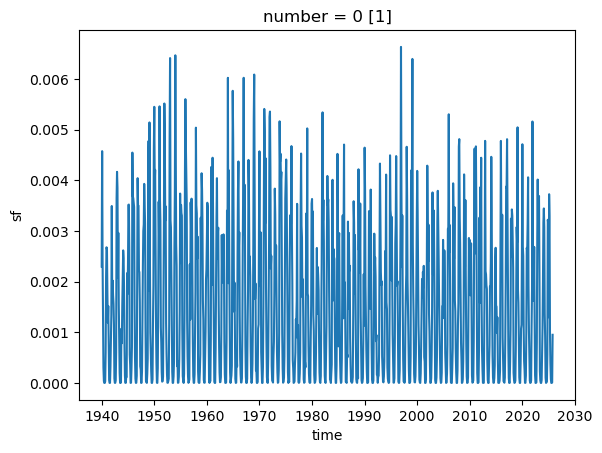

In [6]:
# Now that we have isolated the "snowy" areas, I am spatially averaging 
# snowfall to see check out trends over time and decompose the time series.

ds_snow_avg = ds_snow.mean(dim=["latitude", "longitude"])
ds_snow_avg['sf'].plot()

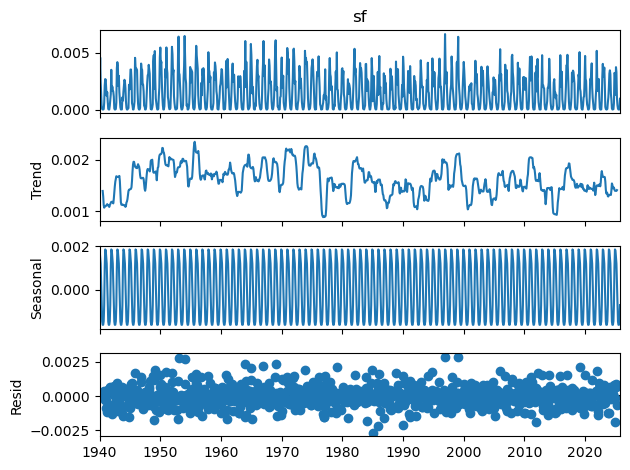

In [7]:
# Now we decompose!

series = ds_snow_avg['sf'].to_pandas()
series = series.asfreq("MS")
result = seasonal_decompose(series, model="additive", period=12)
result.plot()
plt.show()

In [8]:
decomp = pd.DataFrame({'observed': result.observed,'trend': result.trend,'seasonal': result.seasonal,'resid': result.resid})
decomp = decomp.rename_axis('Date')
decomp = decomp.dropna()
decomp

,observed,trend,seasonal,resid
Date,,,,
1940-07-01,9.783916e-09,0.001393,-0.001601,0.000208
1940-08-01,4.943452e-08,0.001289,-0.001597,0.000308
1940-09-01,3.221277e-05,0.001118,-0.001432,0.000346
1940-10-01,5.987952e-04,0.001068,-0.000694,0.000225
1940-11-01,2.099017e-03,0.001086,0.001019,-0.000007
...,...,...,...,...
2024-12-01,3.148596e-03,0.001396,0.001857,-0.000105
2025-01-01,1.296281e-03,0.001395,0.001813,-0.001912
2025-02-01,3.725382e-03,0.001395,0.001477,0.000854


In [9]:
# Next I am going to import the climate datasets (ENSO, PDO, NAO, AO) that we used in M4N1.

clim = xr.open_dataset("clim.nc")
clim_df = clim.to_dataframe()
clim_df

,ENSO,PDO,NAO,AO
Date,,,,
1951-01-01,1.5,-1.19,0.08,-0.085
1951-02-01,0.9,-1.52,0.70,-0.400
1951-03-01,-0.1,-1.72,-1.02,-1.934
1951-04-01,-0.3,-1.35,-0.22,-0.776
1951-05-01,-0.7,-1.29,-0.59,-0.863
...,...,...,...,...
2025-06-01,0.3,-2.62,0.70,1.134
2025-07-01,0.6,-4.18,0.48,0.500
2025-08-01,0.4,-3.19,0.26,0.036


In [10]:
# and now I want to merge all data together along the time axis

all = clim_df.join(decomp)
all

,ENSO,PDO,NAO,AO,observed,trend,seasonal,resid
Date,,,,,,,,
1951-01-01,1.5,-1.19,0.08,-0.085,0.005460,0.001889,0.001813,0.001758
1951-02-01,0.9,-1.52,0.70,-0.400,0.003606,0.001891,0.001477,0.000238
1951-03-01,-0.1,-1.72,-1.02,-1.934,0.003197,0.001886,0.001208,0.000103
1951-04-01,-0.3,-1.35,-0.22,-0.776,0.001097,0.001883,0.000258,-0.001044
1951-05-01,-0.7,-1.29,-0.59,-0.863,0.000797,0.001870,-0.000855,-0.000219
...,...,...,...,...,...,...,...,...
2025-06-01,0.3,-2.62,0.70,1.134,NaN,NaN,NaN,NaN
2025-07-01,0.6,-4.18,0.48,0.500,NaN,NaN,NaN,NaN
2025-08-01,0.4,-3.19,0.26,0.036,NaN,NaN,NaN,NaN


In [11]:
# It is apparent that the climate indices dataset includes more months of data than
# the sf dataset. Lets drop those extra rows! In addition, I don't currently need
# the observed/seasonal/resid columns.

all_refined = all.drop(columns=["observed", "seasonal", "resid"]).dropna()
all_refined

,ENSO,PDO,NAO,AO,trend
Date,,,,,
1951-01-01,1.5,-1.19,0.08,-0.085,0.001889
1951-02-01,0.9,-1.52,0.70,-0.400,0.001891
1951-03-01,-0.1,-1.72,-1.02,-1.934,0.001886
1951-04-01,-0.3,-1.35,-0.22,-0.776,0.001883
1951-05-01,-0.7,-1.29,-0.59,-0.863,0.001870
...,...,...,...,...,...
2024-12-01,1.2,-2.03,1.21,-0.335,0.001396
2025-01-01,0.2,-1.28,-0.52,-0.069,0.001395
2025-02-01,0.5,-1.40,1.60,-0.864,0.001395


In [12]:
# We need to establish the features matrix and target array
X_dsfeatures = all_refined.drop('trend', axis=1)
X_dsfeatures.shape

(892, 4)

In [13]:
y_dstarget = all_refined['trend']
y_dstarget.shape

(892,)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_dsfeatures, y_dstarget, random_state=0,
                                  train_size=0.7)

In [15]:
# train model on training dataset
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [16]:
# Predict results based on the each dataset
y_pred_from_train = model.predict(X_train)
y_pred = model.predict(X_test)

In [17]:
# Test the performance of this mdodel 

test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
corr = np.corrcoef(y_test, y_pred)[0, 1]
print("Correlation Coefficient:", corr)
print("Testing Set R² Score:", test_r2)
print("Testing Set Root Mean Squared Error:", test_rmse)


Correlation Coefficient: 0.4371863848167656
Testing Set R² Score: 0.1738677770200069
Testing Set Root Mean Squared Error: 0.0002703300334024248


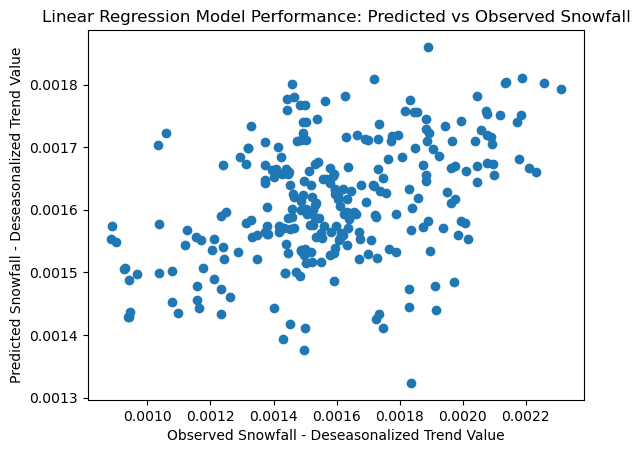

In [18]:
plt.scatter(y_test, y_pred)
plt.xlabel("Observed Snowfall - Deseasonalized Trend Value")
plt.ylabel("Predicted Snowfall - Deseasonalized Trend Value")
plt.title("Linear Regression Model Performance: Predicted vs Observed Snowfall")
plt.show()

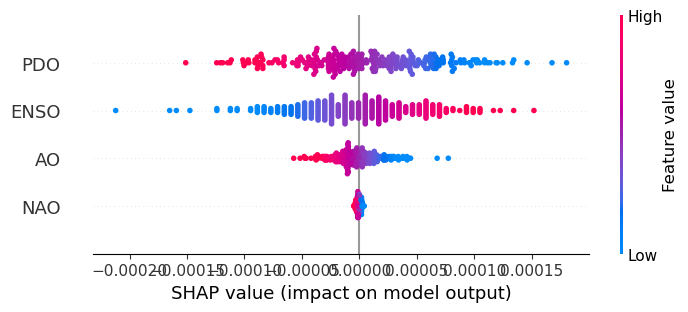

In [19]:
shap.initjs()

explainer = shap.Explainer(model, X_train, feature_names=X_dsfeatures.columns)
shap_values = explainer(X_test)  # shap.Explanation
shap_values

shap.plots.beeswarm(shap_values, max_display=12)

Another idea to try: resample so that data is not available per month but there is one value per year? and it is the sum of annual snowfall.

In [20]:
# I want to see if we can get a better model with a polynomial regression model
# Import libraries and this code block from M5N4 to define PolynomialRegression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(),
                         LinearRegression(**kwargs))

In [21]:
# Define parameter grid
param_grid = {'polynomialfeatures__degree': np.arange(0,10),
              'linearregression__fit_intercept': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=4, n_jobs=-1)

In [22]:
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best cross-validated R²:", grid.best_score_)
best_polynomial = grid.best_estimator_

Best parameters: {'linearregression__fit_intercept': True, 'polynomialfeatures__degree': np.int64(2)}
Best cross-validated R²: 0.11567851976477206


In [23]:
# Predict on both training and test data
y_pred_train_pn = best_polynomial.predict(X_train)
y_pred_test_pn = best_polynomial.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train_pn)
train_mse = mean_squared_error(y_train, y_pred_train_pn)
train_rmse = np.sqrt(train_mse)

test_r2 = r2_score(y_test, y_pred_test_pn)
test_mse = mean_squared_error(y_test, y_pred_test_pn)
test_rmse = np.sqrt(test_mse)

print("Training Set R² Score:", train_r2)
print("Testing Set R² Score:", test_r2)
print("Training Set Root Mean Squared Error:", train_rmse)
print("Testing Set Root Mean Squared Error:", test_rmse)

Training Set R² Score: 0.16433010725018704
Testing Set R² Score: 0.22381456473272454
Training Set Root Mean Squared Error: 0.00024430380434457805
Testing Set Root Mean Squared Error: 0.0002620307510524336


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X_dsfeatures, y_dstarget).predict(X_test)
